In [2]:
#load data from files
from PIL import Image
import os, os.path
import glob
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader 
from sklearn import preprocessing as pc


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
transform = transforms.Compose(
    [transforms.Resize((150,150)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

labels_dic = {"buildings": 0, "forest": 1, "glacier" : 2, "mountain" : 3, "sea" : 4, "street" : 5}

encoder = {0: "buildings", 1: "forest", 2 : "glacier", 3 : "mountain", 4: "sea", 5: "street"}

def load_data(data):
    images = []
    classes = ["building", "forest", "glacier", "mountain", "sea", "street"]
    labels = []
    for i in classes:
        path = os.path.join((f"/content/{data}"),i)
        path += "/*.jpg"
        for file in glob.glob(path):
            labels.append(labels_dic[i])
            im = Image.open(file)
            images.append(transform(im))
            im.close()
    return images, labels


#take big ass chucnk of data test_x
#shuffle data
train_set = load_data("train")



In [12]:
#split data
size = 100
shuffle_iters = len(train_set[0])/size

def split_data(data_set): 
    pile = []
    i = 0
    while i < len(data_set)-100:
        if (len(data_set) - size) < size:
            pile.append(data_set[i:i+len(data_set)])
           #break
        pile.append(data_set[i:i+size])
        i += size
    return pile

trainset_x = split_data(train_set[0])
trainset_y = split_data(train_set[1])


In [13]:
#shuffle data 
def shuffle_data(data_set):
    size = int(len(data_set)/2)
    result_data = []
    counter_x = 0
    counter_y = size
    for i in range(size):
        x = data_set[counter_x]
        y = data_set[counter_y]
        result_data.append(y)
        result_data.append(x)
        counter_x += 1
        counter_y += 1
    return result_data
    
trainset_x = shuffle_data(trainset_x)
trainset_y = shuffle_data(trainset_y)

In [14]:
def flatten_x(l):
    data_x = []
    for i in l:
        data_x += i
    return data_x
    
train_x = flatten_x(trainset_x)

def flatten_y(l):
    return [item for sublist in l for item in sublist] #stackoverflow provieds nicest list comprehensions 

train_y = flatten_y(trainset_y)

In [15]:
class Mydata(Dataset):
    
    def __init__(self, x, y): 
        self.x = x
        self.y = y
        self.len = len(x)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.x[idx] , self.y[idx]
        

In [16]:
trainset = Mydata(train_x, train_y)

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(3, 6, 6)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.conv3 = nn.Conv2d(12, 24, 3)
        self.conv4 = nn.Conv2d(24, 12, 3)
        self.fc1 = nn.Linear(588, 244)
        self.fc2 = nn.Linear(244, 6)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #fully connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()

In [18]:
if torch.cuda.is_available():
    model.cuda()
import torch.optim as optim

lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [20]:
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

In [30]:
# accuracy of model :
batch_size = 1000
testloader = DataLoader(testset, batch_size=batch_size)

total = 0
correct = 0
with torch.no_grad():
  for i,(inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    out = model(inputs)
    _, out_hat = torch.max(out, 1)
    total += labels.size(0)
    correct += (out_hat == labels).sum().item()

print(f"Accuracy of the network on the {batch_size} test images: {(100 * correct / total):.2f}")

Accuracy of the network on the 1000 test images: 79.67


In [90]:
n_iters = 100

for epoch in range(n_iters):
  Loss = []
  print(f"\n-----epoch:{epoch+1}-----\n")
  for i, (inputs, labels) in enumerate(trainloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    out = model(inputs)
    loss = criterion(out,labels)
    loss.backward()
    optimizer.step()
    if i % 10 == 0: 
      print(f"running_loss: {loss.item()}")
      #print(inputs.shape)
    Loss.append(loss.item())
  print(f"\n loss_model: {sum(Loss)/len(Loss)}")


-----epoch:1-----

running_loss: 0.007604454644024372
running_loss: 0.001221782760694623
running_loss: 0.004601210355758667
running_loss: 0.024666018784046173
running_loss: 0.0737241879105568
running_loss: 0.08423712849617004
running_loss: 0.09151618182659149
running_loss: 0.17545320093631744
running_loss: 0.4639785885810852
running_loss: 0.03190723806619644
running_loss: 0.07965719699859619
running_loss: 0.0842335894703865

 loss_model: 0.09751682643683911

-----epoch:2-----

running_loss: 0.043454691767692566
running_loss: 0.07752881199121475
running_loss: 0.06546510010957718
running_loss: 0.01797487586736679
running_loss: 0.02845758944749832
running_loss: 0.05312497168779373
running_loss: 0.013164316304028034
running_loss: 0.04254300147294998
running_loss: 0.015190777368843555
running_loss: 0.016898060217499733
running_loss: 0.0621236190199852
running_loss: 0.03511269390583038

 loss_model: 0.04623419879659442

-----epoch:3-----

running_loss: 0.03844846785068512
running_loss: 0.00

In [97]:
# load, split, shuffle test_data
batch_size = 500
test_set = load_data("test")
testset_x = split_data(test_set[0])
testset_y = split_data(test_set[1])
testset_x = shuffle_data(testset_x)
testset_y = shuffle_data(testset_y)
test_x = flatten_x(testset_x)
test_y = flatten_y(testset_y)
testset = Mydata(test_x, test_y)

testloader = DataLoader(testset, batch_size=batch_size , shuffle=False)

In [98]:
total = 0
correct = 0
with torch.no_grad():
  for i, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    out = model(inputs)
    _, out_hat = torch.max(out , 1)
    total += labels.size(0)
    correct += (out_hat == labels).sum().item()

print(f'Accuracy of the Model: {(100 * correct / total):.2f}%')

Accuracy of the Model: 81.46%


In [92]:
#Not bad i think, but we 
#have very low loss while accuracy isn't extremly high -> overfitting , 81% seems fine though 
#still overfiting but much better results than before, shuffeling data and reducing the cnn size helped
#With data augmentation we could try to improve over all accuracy 

In [93]:
def load_data_pred():
    images = []
    labels = []
    path = ("/content/pred/*jpg")
    for file in glob.glob(path):
      im = Image.open(file)
      images.append(transform(im))
      im.close()
      labels.append(0)
    return images,labels



pred_set = load_data_pred()

In [94]:
class Data_pred(Dataset):
    
    def __init__(self, data): 
        self.x = data[0]
        self.y = data[1]
        self.len = len(data[0])
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.x[idx] , self.y[idx]

In [95]:
pred_data = Data_pred(pred_set)

preddataloader = DataLoader(pred_data, batch_size=5, shuffle=True)


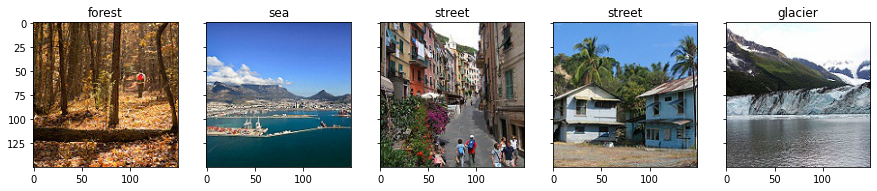

In [99]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(1,5, figsize=(15, 10), sharey=True)

labels_predicted = []

inputs_pred, labels_pred = next(iter(preddataloader))
inputs_pred, labels_pred = inputs_pred.to(device), labels_pred.to(device)
out = model(inputs_pred)
_, out_hat = torch.max(out, 1)


labels_predicted = [encoder[out_hat[i].item()] for i in range(len(out_hat))]




for i in range(5):
  label = encoder[out_hat[i].item()]
  inputs_pred[i] = inputs_pred[i]/2 + 0.5 #undo normalize
  im = inputs_pred[i]
  im = im.cpu().data.numpy()
  axs[i].imshow(np.transpose(im, (1,2,0)))
  axs[i].title.set_text(labels_predicted[i])

plt.show()


In [85]:
#im pretty happy with the results for a very simpel CNN to be honest